In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly.graph_objects as go

# path to files
file_path_gps  = r"C:\Users\d85335mt\OneDrive - The University of Manchester\Desktop\MGGA_exersice\20250317-113726 - Test.txt"
file_path_mgga = r"C:\Users\d85335mt\OneDrive - The University of Manchester\Desktop\MGGA_exersice\micro2002-01-01_f0044.txt"

# read files as pandas dataframes
gps_data  = pd.read_csv(file_path_gps)
mgga_data = pd.read_csv(file_path_mgga)


In [3]:
# Clean up column names (strip leading/trailing spaces)
mgga_data.columns = mgga_data.columns.str.strip()
# Strip spaces from string values in all columns
# This ensures no leading/trailing spaces remain in string-based columns
mgga_data = mgga_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

print (mgga_data.columns)
print (gps_data.columns)

print (gps_data.shape)
print (mgga_data.shape)

Index(['Time', 'BattPer', '[CH4]_ppm', '[CH4]_ppm_sd', '[H2O]_ppm',
       '[H2O]_ppm_sd', '[CO2]_ppm', '[CO2]_ppm_sd', '[CH4]d_ppm',
       '[CH4]d_ppm_sd', 'GasP_torr', 'GasP_torr_sd', 'GasT_C', 'GasT_C_sd',
       'AmbT_C', 'AmbT_C_sd', 'RD0_raw_us', 'RD0_raw_us_sd', 'RD0_us',
       'RD0_us_sd', 'LTC0_v', 'LTC0_v_sd', 'RD0_raw', 'RD1_raw', 'Fit_Flag',
       'MIU_VALVE', 'MIU_DESC'],
      dtype='object')
Index(['type', 'date time', 'latitude', 'longitude', 'accuracy(m)',
       'altitude(m)', 'geoid_height(m)', 'speed(m/s)', 'bearing(deg)',
       'sat_used', 'sat_inview', 'name', 'desc'],
      dtype='object')
(196, 13)
(5302, 27)


In [4]:
# convert dates to pandas datetime objects 
gps_data['date time'] = pd.to_datetime(gps_data['date time'], format='%Y-%m-%d %H:%M:%S')
# mgga_data['Time'] = pd.to_datetime(mgga_data['Time'], format='%Y-%m-%d %H:%M:%S')

### methane correction for interfearence with water vapor
## constants 

alpha    = -1.55636 
beta     = -12.25066 
a        = -0.00031  
b        = -0.00019   
C        = 0.01323  #(ppm)
G        = 0.99697 
sigma_nu = 0.00043 
sigma_G  = 0.00023 
sigma_C  = 0.00203  #(ppm)
sigma_L  = 0.00282  #(ppm)
sigma_n  = 0.00270  #(ppm)

In [5]:
# Corrects the methane concentration (CH4_wet_ppm) based on water vapor effects.
# Uses empirical correction factors (L18, L19, L20, L21, G, C) that have been determined through experimental calibration.
# The equation ensures that the methane concentration is adjusted for water vapor interference, which affects gas analyzers.
# Many methane sensors use infrared absorption spectroscopy to measure CH₄.
# Water vapor also absorbs infrared light at similar wavelengths as methane.
# This interference increases the detected methane concentration, making it appear higher than it actually is.

mgga_data['[CH4]_ppm_corrected'] = (mgga_data['[CH4]_ppm'] * G / (1 + (alpha * (( mgga_data['[H2O]_ppm'] / 1000000) - (a + (b*mgga_data['[CH4]_ppm'])))) + 
                                                        (beta*((mgga_data['[H2O]_ppm'] /1000000)-(a+  (b*mgga_data['[CH4]_ppm'])))* (( mgga_data['[H2O]_ppm'] /1000000) - 
                                                                                                                            (a +  (b*mgga_data['[CH4]_ppm'])))))) + C 
## methane uncertainty 
mgga_data['[CH4]_ppm_uncertainty'] = np.sqrt((((mgga_data['[CH4]_ppm']/(1 + (alpha *((mgga_data['[H2O]_ppm']/1000000) - (a + (b*mgga_data['[CH4]_ppm'])))) + 
                                                             (beta*((mgga_data['[H2O]_ppm']/1000000) - (a + (b*mgga_data['[CH4]_ppm'])))*((mgga_data['[H2O]_ppm']/1000000) - 
                                                                (a + (b*mgga_data['[CH4]_ppm']))))))**2)*(((sigma_nu*G)**2) + ((sigma_G*(1 + (alpha *((mgga_data['[H2O]_ppm']/1000000) - 
                                                                (a + (b*mgga_data['[CH4]_ppm'])))) + (beta*((mgga_data['[H2O]_ppm']/1000000) - (a + (b*mgga_data['[CH4]_ppm'])))*
                                                                ((mgga_data['[H2O]_ppm']/1000000) - (a + (b*mgga_data['[CH4]_ppm']))))))**2))) + (sigma_C**2) + (sigma_L**2) + (sigma_n**2))

In [6]:
###############################################################
# here I copy the timestamp to make the script run 
# it needs corrections to either interpolate to this timestamp 
# or if they match do nothing just combine the data 
n_gps = gps_data.shape[0]
mgga_data = mgga_data.iloc[0:n_gps,:]
print (mgga_data.shape)
mgga_data['Time'] = gps_data['date time']
################################################################

(196, 29)


In [7]:
# add latitude and longitude info to measurements 
mgga_data['latitude'] = gps_data['latitude']
mgga_data['longitude'] = gps_data['longitude']
print (mgga_data.head(10))
print (gps_data.head(10))

                 Time  BattPer  [CH4]_ppm  [CH4]_ppm_sd  [H2O]_ppm  \
0 2025-03-17 11:37:26  64.3661  -0.057498           0.0    1876.76   
1 2025-03-17 11:37:27  68.7135   2.063670           0.0    4062.48   
2 2025-03-17 11:37:28  68.9806   2.072580           0.0    4154.83   
3 2025-03-17 11:37:29  69.4402   2.075480           0.0    4271.42   
4 2025-03-17 11:37:30  69.0155   2.072160           0.0    4392.72   
5 2025-03-17 11:37:31  70.2573   2.072440           0.0    4085.56   
6 2025-03-17 11:37:32  69.9566   2.072520           0.0    4247.16   
7 2025-03-17 11:37:33  70.1323   2.071220           0.0    4019.16   
8 2025-03-17 11:37:34  69.9502   2.068170           0.0    4045.02   
9 2025-03-17 11:37:35  70.1623   2.070800           0.0    4055.45   

   [H2O]_ppm_sd  [CO2]_ppm  [CO2]_ppm_sd  [CH4]d_ppm  [CH4]d_ppm_sd  ...  \
0           0.0   -417.971           0.0   -0.057606            0.0  ...   
1           0.0    471.745           0.0    2.072090            0.0  ...   
2

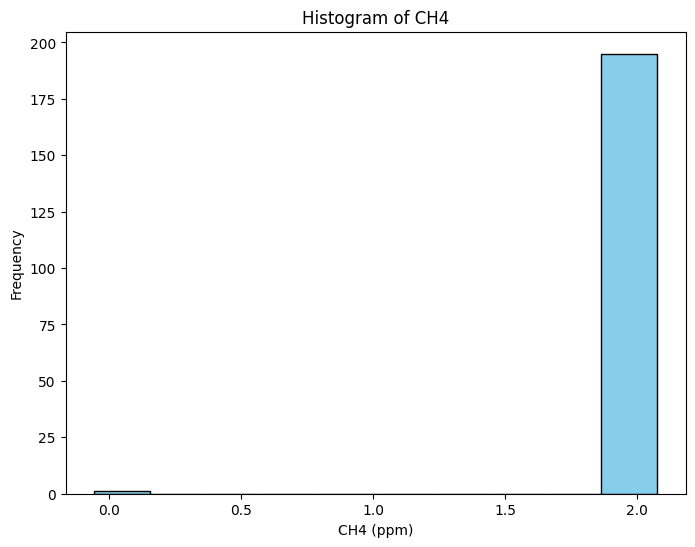

In [8]:
# plot histogram for CH4 
plt.figure(figsize=(8, 6))
plt.hist(mgga_data['[CH4]_ppm'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of CH4')
plt.xlabel('CH4 (ppm)')
plt.ylabel('Frequency')
plt.show()


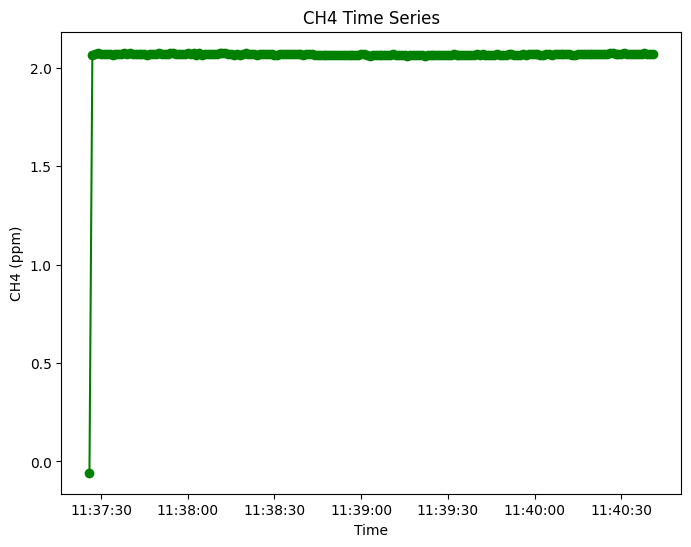

In [9]:
# Plot Time Series for CH4 
plt.figure(figsize=(8, 6))
plt.plot(mgga_data['Time'], mgga_data['[CH4]_ppm'], color='green', marker='o', linestyle='-')
plt.title('CH4 Time Series')
plt.xlabel('Time')
plt.ylabel('CH4 (ppm)')
plt.show()


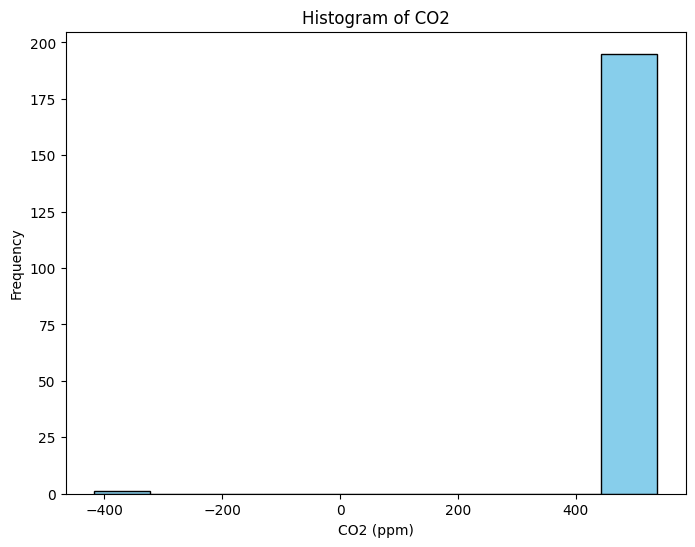

In [10]:
# Plot Histogram for CO2
plt.figure(figsize=(8, 6))
plt.hist(mgga_data['[CO2]_ppm'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of CO2')
plt.xlabel('CO2 (ppm)')
plt.ylabel('Frequency')
plt.show()

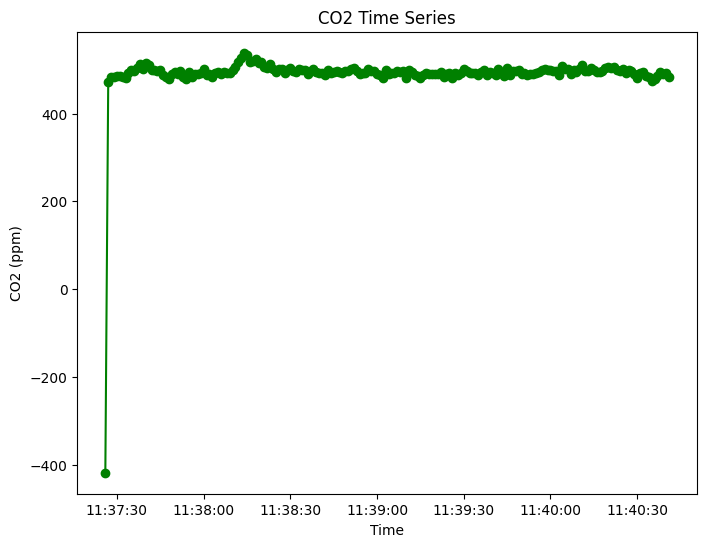

In [11]:
# Plot Time Series for CO2 
plt.figure(figsize=(8, 6))
plt.plot(mgga_data['Time'], mgga_data['[CO2]_ppm'], color='green', marker='o', linestyle='-')
plt.title('CO2 Time Series')
plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.show()

In [12]:
# Create a Plotly figure with Mapbox tiles
fig = go.Figure(go.Scattermap(
    lat= mgga_data['latitude'],  # Use the latitude values from your DataFrame
    lon= mgga_data['longitude'],  # Use the longitude values from your DataFrame
    mode='markers',
    marker={'size': 12, 'color': mgga_data['[CH4]_ppm'], 'colorscale': 'Viridis', 'colorbar': {'title': 'CH4 Levels'},
            'cmin': 0.,  # Set minimum value for color scale
        'cmax': 3.,  # Set maximum value for color scale
         },  # Color by CH4 values
    text= mgga_data['[CH4]_ppm'],  # Display CH4 value on hover
))

# Set up Mapbox style and layout
fig.update_layout(
    mapbox_style="open-street-map",  # Use OpenStreetMap tiles for the base map
    mapbox_zoom=12,  # Zoom level
    mapbox_center={"lat": mgga_data['latitude'].mean(), "lon": mgga_data['longitude'].mean()},  # Center map on the average lat/lon
    title="City Locations with CH4 Levels",
)

# Show the map
fig.show()

AttributeError: module 'plotly.graph_objects' has no attribute 'Scattermap'

In [ ]:
# Create a Plotly figure with Mapbox tiles
fig = go.Figure(go.Scattermap(
    lat= mgga_data['latitude'],  # Use the latitude values from your DataFrame
    lon= mgga_data['longitude'],  # Use the longitude values from your DataFrame
    mode='markers',
    marker={'size': 12, 'color': mgga_data['[CO2]_ppm'], 'colorscale': 'Viridis', 'colorbar': {'title': 'CO2 Levels'},
        'cmin': 0.,  # Set minimum value for color scale
        'cmax': 3.,  # Set maximum value for color scale
         },
    text= mgga_data['[CO2]_ppm'],  # Display CH4 value on hover
))

# Set up Mapbox style and layout
fig.update_layout(
    mapbox_style="open-street-map",  # Use OpenStreetMap tiles for the base map
    mapbox_zoom=12,  # Zoom level
    mapbox_center={"lat": mgga_data['latitude'].mean(), "lon": mgga_data['longitude'].mean()},  # Center map on the average lat/lon
    title="City Locations with CO2 Levels",
)

# Show the map
fig.show()

AttributeError: module 'plotly.graph_objects' has no attribute 'Scattermap'